In [ ]:
pip install librosa tensorflow numpy matplotlib scikit-learn

In [1]:
import os
import librosa
import numpy as np

In [2]:
# Function to extract features from an audio file
def extract_features(audio_path):
    try:
        audio_data, sample_rate = librosa.load(audio_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        # Add other features as needed
        features = np.mean(mfccs, axis=1)
        return features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [3]:
import os
from tqdm import tqdm  # Import tqdm for progress tracking

dataset_root = "All"

# Define the classes (animal names)
classes = ['Birds','Dog','Elephant', 'Leopard', 'Tiger']

X = []  # List to store features
y = []  # List to store labels

# Calculate total number of files
total_files = sum(len(os.listdir(os.path.join(dataset_root, cls))) for cls in classes)

# Create a tqdm progress bar
with tqdm(total=total_files, desc="Processing Audio Files", unit="file") as pbar:
    for class_name in classes:
        class_folder = os.path.join(dataset_root, class_name)

        # Iterate through audio files in the class folder
        for audio_file in os.listdir(class_folder):
            audio_path = os.path.join(class_folder, audio_file)

            # Extract features from the audio file
            features = extract_features(audio_path)

            if features is not None:
                X.append(features)
                y.append(classes.index(class_name))

            # Update the progress bar
            pbar.update(1)

print("Feature extraction completed!")


Processing Audio Files:   0%|          | 0/1976 [00:00<?, ?file/s]

Processing Audio Files: 100%|██████████| 1976/1976 [01:05<00:00, 30.09file/s]

Feature extraction completed!


In [4]:
X = np.array(X)
y = np.array(y)


In [5]:
from keras.utils import to_categorical
y_categorical = to_categorical(y)

In [6]:
y_categorical

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

# Define input shape
input_length = X_train.shape[1]  # Number of features
num_classes = y_categorical.shape[1]  # Number of classes

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification


In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [26]:
epochs = 20
batch_size = 32

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4782 - loss: 2.0378 - val_accuracy: 0.8535 - val_loss: 0.4100
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8804 - loss: 0.3475 - val_accuracy: 0.9066 - val_loss: 0.3019
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9357 - loss: 0.2311 - val_accuracy: 0.9141 - val_loss: 0.2507
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9471 - loss: 0.1835 - val_accuracy: 0.9369 - val_loss: 0.1790
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9621 - loss: 0.1346 - val_accuracy: 0.9545 - val_loss: 0.1388
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9668 - loss: 0.1120 - val_accuracy: 0.9621 - val_loss: 0.1180
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9820 - loss: 0.0856 - val_accuracy: 0.9646 - val_loss: 0.0974
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9806 - loss: 0.0714 - val_accuracy: 0.9722 - val_loss:

In [27]:
model.save('past.h5')


In [29]:
from keras.models import load_model

model_path = 'past.h5'
loaded_model = load_model(model_path)


In [30]:
def extract_and_preprocess_features(audio_path, expected_shape):
    try:
        audio_data, sample_rate = librosa.load(audio_path, sr=None)

        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        zcr = librosa.feature.zero_crossing_rate(y=audio_data)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)

        mfcc_mean = np.mean(mfccs, axis=1)
        zcr_mean = np.mean(zcr, axis=1)
        mel_mean = np.mean(mel_spectrogram, axis=1)
        chroma_mean = np.mean(chroma, axis=1)

        combined_features = np.concatenate((mfcc_mean, zcr_mean, mel_mean, chroma_mean))

        if combined_features.shape[0] < expected_shape[0]:
            padding = np.zeros(expected_shape[0] - combined_features.shape[0])
            combined_features = np.concatenate((combined_features, padding))
        elif combined_features.shape[0] > expected_shape[0]:
            combined_features = combined_features[:expected_shape[0]]

        return combined_features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None


In [35]:
print(f"Expected shape: {expected_input_shape}")
print(f"Actual shape: {new_audio_features.shape}")


Expected shape: (20, 1)
Actual shape: (1, 20, 1)


# new

In [6]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm  # Progress ba

In [8]:
# Function to extract and preprocess features from an audio file
def extract_and_preprocess_features(audio_path, expected_shape):
    try:
        audio_data, sample_rate = librosa.load(audio_path, sr=None)

        # Extract features
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        zcr = librosa.feature.zero_crossing_rate(y=audio_data)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)

        # Compute mean values
        mfcc_mean = np.mean(mfccs, axis=1)
        zcr_mean = np.mean(zcr, axis=1)
        mel_mean = np.mean(mel_spectrogram, axis=1)
        chroma_mean = np.mean(chroma, axis=1)

        # Combine features
        combined_features = np.concatenate((mfcc_mean, zcr_mean, mel_mean, chroma_mean))

        # Ensure consistent shape
        if combined_features.shape[0] < expected_shape[0]:
            padding = np.zeros(expected_shape[0] - combined_features.shape[0])
            combined_features = np.concatenate((combined_features, padding))
        elif combined_features.shape[0] > expected_shape[0]:
            combined_features = combined_features[:expected_shape[0]]

        return combined_features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [9]:
# Dataset Path
dataset_root = "All/"
classes = ["Birds", "Dog", "Elephant", "Leopard", "Tiger"]
expected_input_shape = (1216,)

# Load dataset with tqdm progress bar
X, y = [], []
for label, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_root, class_name)
    if not os.path.exists(class_folder):
        print(f"Warning: Folder {class_folder} not found!")
        continue

    file_list = os.listdir(class_folder)
    
    for file_name in tqdm(file_list, desc=f"Processing {class_name}", total=len(file_list)):
        file_path = os.path.join(class_folder, file_name)
        features = extract_and_preprocess_features(file_path, expected_input_shape)
        if features is not None:
            X.append(features)
            y.append(label)

Processing Tiger: 100%|██████████| 400/400 [00:24<00:00, 16.06it/s]


In [10]:
# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

In [14]:



# Model definition
model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(len(classes), activation="softmax")  # Output layer
])

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save model
model.save("past.h5")


Epoch 1/20
50/50 [==============================] - 2s 15ms/step - loss: 2.8921 - accuracy: 0.6601 - val_loss: 0.4911 - val_accuracy: 0.8687
Epoch 2/20
50/50 [==============================] - 1s 10ms/step - loss: 0.6496 - accuracy: 0.8152 - val_loss: 0.1529 - val_accuracy: 0.9646
Epoch 3/20
50/50 [==============================] - 1s 10ms/step - loss: 0.4313 - accuracy: 0.8595 - val_loss: 0.1367 - val_accuracy: 0.9596
Epoch 4/20
50/50 [==============================] - 1s 10ms/step - loss: 0.2854 - accuracy: 0.8981 - val_loss: 0.0880 - val_accuracy: 0.9722
Epoch 5/20
50/50 [==============================] - 1s 10ms/step - loss: 0.1957 - accuracy: 0.9354 - val_loss: 0.0697 - val_accuracy: 0.9848
Epoch 6/20
50/50 [==============================] - 1s 10ms/step - loss: 0.1312 - accuracy: 0.9595 - val_loss: 0.0409 - val_accuracy: 0.9924
Epoch 7/20
50/50 [==============================] - 1s 10ms/step - loss: 0.0814 - accuracy: 0.9715 - val_loss: 0.0292 - val_accuracy: 0.9899
Epoch 8/20
50

In [4]:
import os
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("past.h5")

# New audio folder path
new_audio_folder = "All/Tiger/"
expected_input_shape = (1216,)  # Match the expected input shape from the training phase
elephant_count = 0

# Function to extract features and preprocess the audio
def extract_and_preprocess_features(audio_path, expected_shape):
    try:
        audio_data, sample_rate = librosa.load(audio_path, sr=None)

        # Extract features
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        zcr = librosa.feature.zero_crossing_rate(y=audio_data)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)

        # Compute mean values
        mfcc_mean = np.mean(mfccs, axis=1)
        zcr_mean = np.mean(zcr, axis=1)
        mel_mean = np.mean(mel_spectrogram, axis=1)
        chroma_mean = np.mean(chroma, axis=1)

        # Combine features
        combined_features = np.concatenate((mfcc_mean, zcr_mean, mel_mean, chroma_mean))

        # Ensure consistent shape
        if combined_features.shape[0] < expected_shape[0]:
            padding = np.zeros(expected_shape[0] - combined_features.shape[0])
            combined_features = np.concatenate((combined_features, padding))
        elif combined_features.shape[0] > expected_shape[0]:
            combined_features = combined_features[:expected_shape[0]]

        return combined_features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Iterate through all audio files in the folder
for audio_file in os.listdir(new_audio_folder):
    audio_path = os.path.join(new_audio_folder, audio_file)

    # Extract features from the audio file
    new_audio_features = extract_and_preprocess_features(audio_path, expected_input_shape)

    if new_audio_features is not None:
        # Reshape the features to match the model input
        new_audio_features = new_audio_features.reshape(1, -1)  # Flatten into a single row for prediction

        # Make predictions
        predictions = loaded_model.predict(new_audio_features)
        predicted_class_labels = np.argmax(predictions, axis=1)

        # Define class label mapping
        class_label_mapping = {0: 'Birds', 1: 'Dog', 2: 'Elephant', 3: 'Leopard', 4: 'Tiger'}
        predicted_class_name = class_label_mapping[predicted_class_labels[0]]

        # Count Elephant detections
        if predicted_class_name == 'Tiger':
            elephant_count += 1

        # Print results
        print(f"Predicted Class Label for {audio_file}: {predicted_class_name}")

# Print the total number of Elephant detections
print(f"\nTotal Elephant Detections: {elephant_count}")


1/1 [==============================] - 0s 60ms/step
Predicted Class Label for echo_tiger1.wav: Tiger
1/1 [==============================] - 0s 19ms/step
Predicted Class Label for echo_tiger10.wav: Tiger
1/1 [==============================] - 0s 20ms/step
Predicted Class Label for echo_tiger11.wav: Tiger
1/1 [==============================] - 0s 21ms/step
Predicted Class Label for echo_tiger12.wav: Tiger
1/1 [==============================] - 0s 25ms/step
Predicted Class Label for echo_tiger13.wav: Tiger
1/1 [==============================] - 0s 24ms/step
Predicted Class Label for echo_tiger14.wav: Tiger
1/1 [==============================] - 0s 21ms/step
Predicted Class Label for echo_tiger15.wav: Tiger
1/1 [==============================] - 0s 23ms/step
Predicted Class Label for echo_tiger16.wav: Tiger
1/1 [==============================] - 0s 20ms/step
Predicted Class Label for echo_tiger17.wav: Tiger
1/1 [==============================] - 0s 20ms/step
Predicted Class Label for echo_

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
import librosa

# Load the trained model
loaded_model = load_model("past.h5")

# Define class label mapping
class_label_mapping = {0: 'Birds', 1: 'Dog', 2: 'Elephant', 3: 'Leopard', 4: 'Tiger'}

# Function to extract and preprocess features from an MP3 file
def extract_and_preprocess_features(audio_path, expected_shape):
    try:
        audio_data, sample_rate = librosa.load(audio_path, sr=None)

        # Extract features
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        zcr = librosa.feature.zero_crossing_rate(y=audio_data)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)

        # Compute mean values
        mfcc_mean = np.mean(mfccs, axis=1)
        zcr_mean = np.mean(zcr, axis=1)
        mel_mean = np.mean(mel_spectrogram, axis=1)
        chroma_mean = np.mean(chroma, axis=1)

        # Combine features
        combined_features = np.concatenate((mfcc_mean, zcr_mean, mel_mean, chroma_mean))

        # Ensure consistent shape
        if combined_features.shape[0] < expected_shape[0]:
            padding = np.zeros(expected_shape[0] - combined_features.shape[0])
            combined_features = np.concatenate((combined_features, padding))
        elif combined_features.shape[0] > expected_shape[0]:
            combined_features = combined_features[:expected_shape[0]]

        return combined_features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Function to predict class from an MP3 file
def predict_from_mp3(mp3_file_path):
    expected_input_shape = (1216,)  # Expected shape based on the training data
    features = extract_and_preprocess_features(mp3_file_path, expected_input_shape)

    if features is not None:
        # Reshape the features to match the model input
        features = features.reshape(1, -1)  # Reshape to (1, 1216)

        # Make predictions
        predictions = loaded_model.predict(features)
        predicted_class_labels = np.argmax(predictions, axis=1)
        predicted_class_name = class_label_mapping[predicted_class_labels[0]]

        print(f"Predicted Class Label for {mp3_file_path}: {predicted_class_name}")
        return predicted_class_name
    else:
        print(f"Error processing the file: {mp3_file_path}")
        return None

import tkinter as tk
from tkinter import filedialog

def upload_audio_file():
    """Opens a file dialog to select an audio file."""
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(filetypes=[("Audio Files", "*.mp3")])
    return file_path

# Select file
audio_file = upload_audio_file()
print(f"📂 Selected File: {audio_file}")
predicted_class = predict_from_mp3(audio_file)


In [11]:
import os
import numpy as np
from tensorflow.keras.models import load_model
import librosa

# Load the trained model
model = load_model("past.h5")

13/13 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9899
Test Accuracy: 98.99%
Test Loss: 0.0231
13/13 [==============================] - 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

       Birds       0.99      0.98      0.98        82
         Dog       0.99      1.00      0.99        78
    Elephant       1.00      0.99      0.99        70
     Leopard       0.99      0.99      0.99        83
       Tiger       0.99      1.00      0.99        83

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



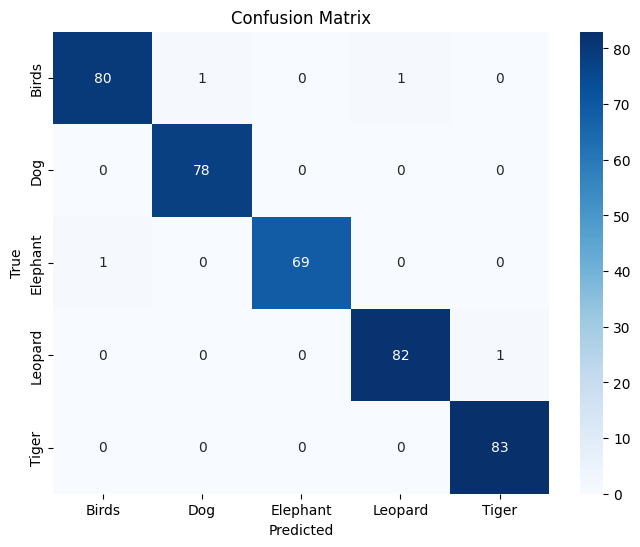

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Print a detailed classification report (Precision, Recall, F1-Score)
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


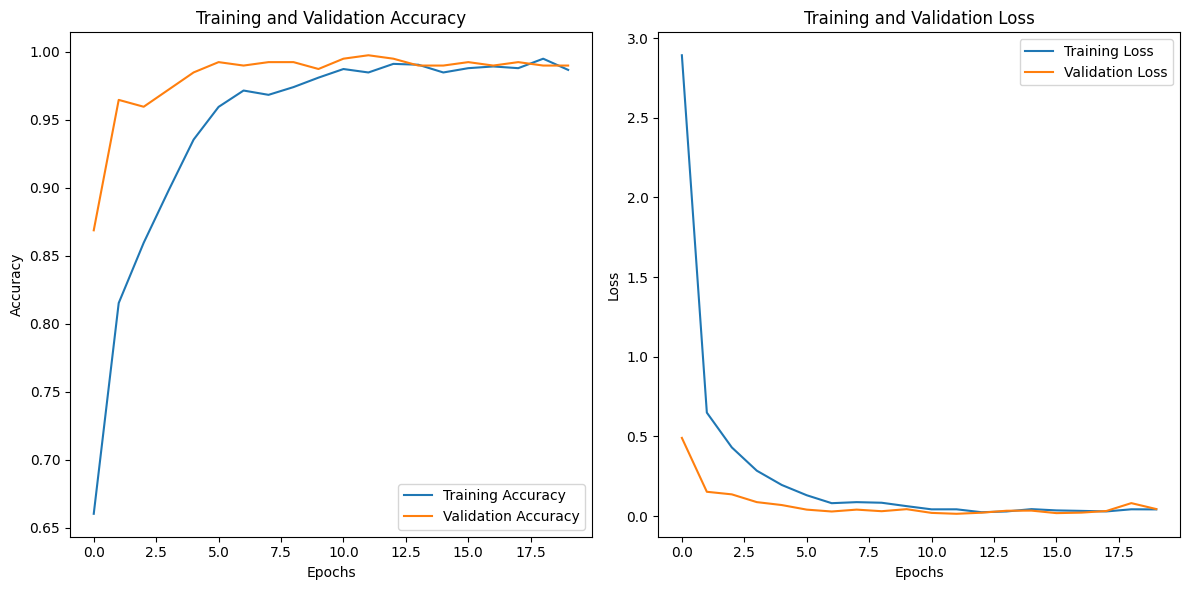

In [15]:
# Assuming you have stored history of training process as `history`
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


13/13 [==============================] - 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

       Birds       1.00      0.96      0.98        82
         Dog       1.00      1.00      1.00        78
    Elephant       1.00      1.00      1.00        70
     Leopard       0.96      0.99      0.98        83
       Tiger       0.99      1.00      0.99        83

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



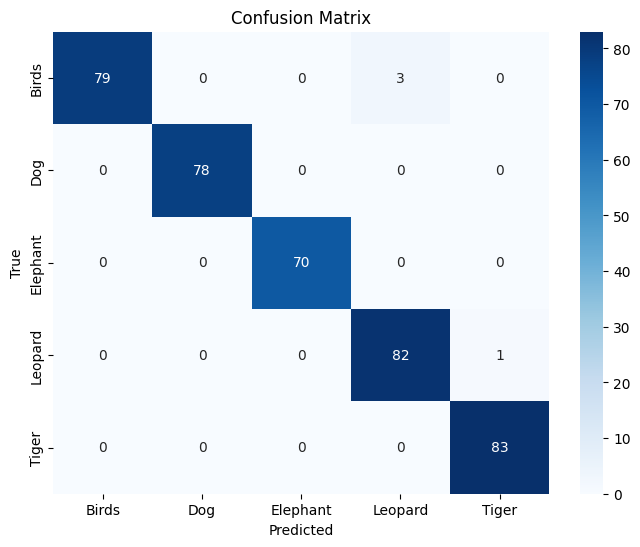

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions for the test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=classes)
print("Classification Report:\n", report)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
